Goal here is to summarize the conditions before Leg 1, during Leg1, between Leg1 and Leg3, and during Leg3.

What timescale to use to combine data over?

Remote sensing data for ocean color and true color, SST?

Leg 1: 2017-09-22 22:34:38.734 to 2017-09-27 12:12:04.202

Leg 2: 2017-09-27 16:36:06.343 to 2017-09-27 12:12:04.202

Leg 3: 2017-09-29 17:27:59.737 to 2017-10-01 17:08:32.915

sat:

- narrow scope of plots
- combine some dateS?

In [1]:
import scs
import pandas as pd
pd.set_option('max_rows', 6)  # max number of rows to show in this notebook — to save space!

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.dates import date2num
import numpy as np
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo
import os
from collections import OrderedDict
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
from scipy.optimize import curve_fit
import shapely

# Read in data

## Station locations

In [6]:
loc = 'data/leg1_latlon.csv'
ll2 = pd.read_csv(loc, index_col=0)
ll2['lat'] = ll2['DegLat'] + ll2['MinLat']/60 + ll2['SecLat']/3600
ll2['lon'] = -(ll2['DegLon'] + ll2['MinLon']/60 + ll2['SecLon']/3600)

# only use subset of stations
ll = ll2.loc[['GI', 'SS', '21', '16', '11', '6', '1']]

## read in SCS data

In [3]:
# leg 1
loc1 = '/Volumes/GoogleDrive/Shared drives/Point Sur Data: Harvey Rapid Response Cruise Oct. 2017/Leg1/PS18_09_Leg1_DiMarco_SCS/Sea-Bird-Thermosalinograph-(converted-ASCII-data)_20170922-223421.Raw'
df1 = scs.read_file(loc1)
print(df1)

# leg 2
loc2 = '/Volumes/GoogleDrive/Shared drives/Point Sur Data: Harvey Rapid Response Cruise Oct. 2017/Leg2/PS18_09_Leg2_Whilden_SCS/Sea-Bird-Thermosalinograph-(converted-ASCII-data)_20170927-162751.Raw'
df2 = scs.read_file(loc2)
print(df2)

# leg 3
loc3 = '/Volumes/GoogleDrive/Shared drives/Point Sur Data: Harvey Rapid Response Cruise Oct. 2017/Leg3/PS18_09_Leg3_Campbell_SCS/Sea-Bird-Thermosalinograph-(converted-ASCII-data)_20170929-172721.Raw'
df3 = scs.read_file(loc3)
print(df3)

                         Conductivity  Practical salinity  Temperature  \
Dates [UTC?]_                                                            
2017-09-22 22:34:38.734      2.377823              13.108       29.412   
2017-09-22 22:34:48.737      2.379329              13.119       29.405   
2017-09-22 22:34:58.735      2.380946              13.130       29.399   
...                               ...                 ...          ...   
2017-09-27 12:11:44.201      3.420782              19.635       29.175   
2017-09-27 12:11:54.205      3.418838              19.625       29.169   
2017-09-27 12:12:04.202      3.417651              19.618       29.166   

                               lat        lon  
Dates [UTC?]_                                  
2017-09-22 22:34:38.734  29.342071 -94.758930  
2017-09-22 22:34:48.737  29.342060 -94.758459  
2017-09-22 22:34:58.735  29.342046 -94.757986  
...                            ...        ...  
2017-09-27 12:11:44.201  29.343685 -94.666004

In [4]:
merc = cartopy.crs.Mercator(central_longitude=-90)
pc = cartopy.crs.PlateCarree()
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['land'])
smin = 22  # min((df1[key].min(), df3[key].min()))
smax = 30  # max((df1[key].max(), df3[key].max()))
s = 150  # scatter marker size

0.13333333333333333

In [178]:
names = ['Dates', 'depth [m]', 'lat', 'latmin', 'latdecmin', 'lon', 'lonmin', 'londecmin']
names2 = ['station', 'depth [m]', 'lat', 'lon', ]
basedir = '/Volumes/GoogleDrive/Shared drives/Point Sur Data: Harvey Rapid Response Cruise Oct. 2017/'
ll3 = pd.read_excel('%s/collection_log/HRR_collection_log.xlsx' % basedir, header=5, usecols=[0,1,2,3,4,5,6,7,8,9], 
                    parse_dates={'Dates': [1,2]}, index_col=1, skiprows=[1240,1241])
ll3.columns = names
ll3['lat'] = ll3.lat + (ll3.latmin + ll3.latdecmin)/60
ll3['lon'] = -(ll3.lon + (ll3.lonmin + ll3.londecmin)/60)

ll3 = ll3.drop(['latmin','latdecmin','lonmin','londecmin'], axis=1)

ll3 = ll3[~ll3.lat.isnull()]

ll3 = ll3.rename({'SA*': 'SA'})

In [179]:
ll3.to_csv('data/ll.csv')

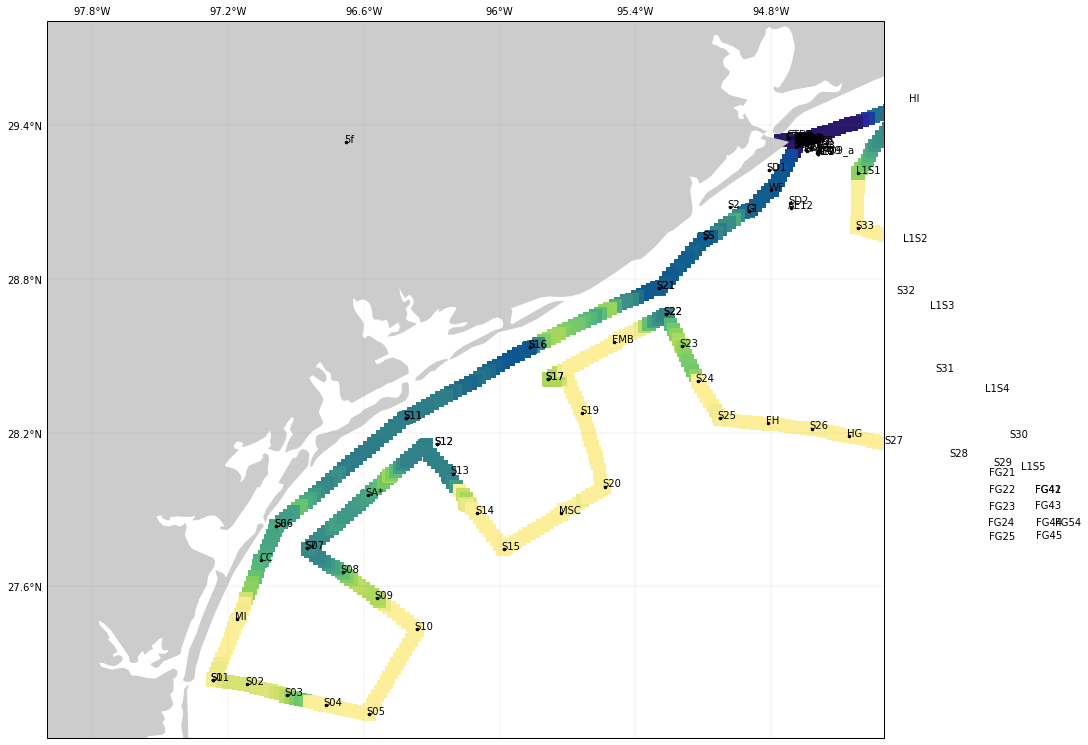

In [149]:
# fig = plt.figure(figsize=(15, 8))# (9.4, 7.7))

fig, axes = plt.subplots(1,1, subplot_kw={'projection': merc}, figsize=(15,15))
ax = axes
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent([-98, -94.3, 27, 29.8], pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False
ax.add_feature(land_10m, facecolor='0.8')
ax.set_facecolor('0.8')

mappable = ax.scatter(df1['lon'][::50], df1['lat'][::50], c=df1['Practical salinity'][::50], s=s, cmap=cmo.haline, transform=pc, 
                      vmin=smin, vmax=smax, marker='s')

# cb = fig.colorbar(mappable)
# cb.set_label('Salinity')

for station in ll3.index:
    lon = ll3['lon'][station]
    lat = ll3['lat'][station]
    if not isinstance(lon, float):
        lon = lon.values[1]
        lat = lat.values[1]
    ax.plot(lon, lat, '.', transform=pc, color='k', markersize=5)
    ax.text(lon - 0.01, lat, station, transform=pc, fontsize=10, color='k')

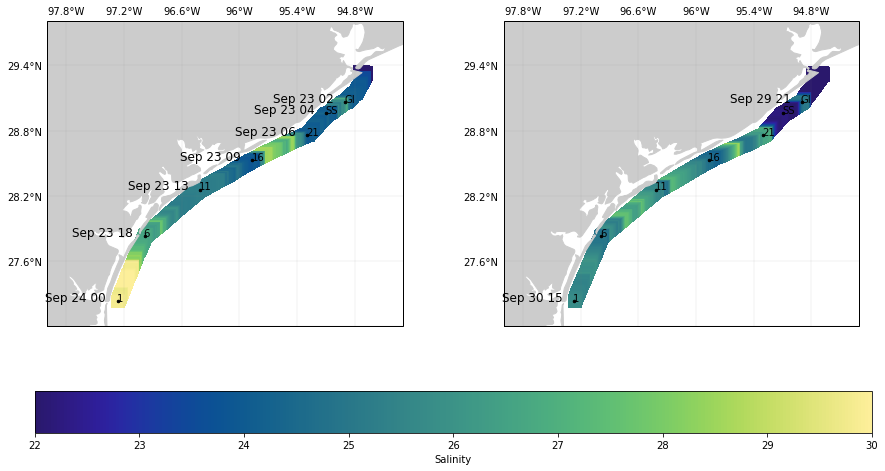

In [87]:
# fig = plt.figure(figsize=(15, 8))# (9.4, 7.7))

fig, axes = plt.subplots(1,2, sharey=True, sharex=True, subplot_kw={'projection': merc}, figsize=(15,8))
ax = axes[0]
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent([-98, -94.3, 27, 29.8], pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False
ax.add_feature(land_10m, facecolor='0.8')
ax.set_facecolor('0.8')

# Find times for when ship is at Stations GI and 1
# minimize distance between ship position and station location
for station in ll.index:
    time = ((df1.lat - ll.loc[station,'lat'])**2 + (df1.lon - ll.loc[station,'lon'])**2).idxmin()
    if station == '1':
        timeS1 = time
    # label times on map
    lon, lat = ll.loc[station,['lon','lat']]
    ax.text(lon - 0.75, lat, time.round('H').strftime('%b %d %H'), transform=pc, fontsize=12, color='k')

# timeGI = ((df1.lat - ll.loc['GI','lat'])**2 + (df1.lon - ll.loc['GI','lon'])**2).idxmin()
# timeS1 = ((df1.lat - ll.loc['1','lat'])**2 + (df1.lon - ll.loc['1','lon'])**2).idxmin()
# label times on map
# lon, lat = ll.loc['GI',['lon','lat']]
# ax.text(lon - 0.75, lat, timeGI.round('H').strftime('%b %d %H'), transform=pc, fontsize=12, color='k')
# lon, lat = ll.loc['1',['lon','lat']]
# ax.text(lon - 0.75, lat, timeS1.round('H').strftime('%b %d %H'), transform=pc, fontsize=12, color='k')
mappable = ax.scatter(df1['lon'][:timeS1], df1['lat'][:timeS1], c=df1['Practical salinity'][:timeS1], s=s, cmap=cmo.haline, transform=pc, 
                      vmin=smin, vmax=smax, marker='s')
# cb = fig.colorbar(mappable)
# cb.set_label('Salinity')
for station in ll.index:
    lon = ll['lon'][station]
    lat = ll['lat'][station]
    ax.plot(lon, lat, '.', transform=pc, color='k', markersize=5)
    ax.text(lon - 0.01, lat, station, transform=pc, fontsize=10, color='k')



# ax = fig.add_subplot(2, 1, 2, projection=merc)
# ax.set_frame_on(False) # kind of like it without the box
# ax.set_extent([-98, -94.3, 27, 29.8], pc)
# gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# # the following two make the labels look like lat/lon format
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER
# gl.xlabels_bottom = False  # turn off labels where you don't want them
# gl.ylabels_right = False
# ax.add_feature(land_10m, facecolor='0.8')
# ax.set_facecolor('0.8')

# # # Find times for when ship is at Stations GI and 1
# # # minimize distance between ship position and station location
# # timeGI = ((df1.lat - ll.loc['GI','lat'])**2 + (df1.lon - ll.loc['GI','lon'])**2).idxmin()
# # timeS1 = ((df1.lat - ll.loc['1','lat'])**2 + (df1.lon - ll.loc['1','lon'])**2).idxmin()
# # # label times on map
# # lon, lat = ll.loc['GI',['lon','lat']]
# # ax.text(lon - 0.75, lat, timeGI.round('H').strftime('%b %d %H'), transform=pc, fontsize=12, color='k')
# # lon, lat = ll.loc['1',['lon','lat']]
# # ax.text(lon - 0.75, lat, timeS1.round('H').strftime('%b %d %H'), transform=pc, fontsize=12, color='k')
# mappable = ax.scatter(df2['lon'][:ind], df2['lat'][:ind], c=df2['Practical salinity'][:ind], s=s, cmap=cmo.haline, transform=pc, 
#                       vmin=smin, vmax=smax, marker='s')
# cb = fig.colorbar(mappable)
# cb.set_label('Salinity')
# for station in ll.index:
#     lon = ll['lon'][station]
#     lat = ll['lat'][station]
#     ax.plot(lon, lat, '.', transform=pc, color='k', markersize=5)
#     ax.text(lon - 0.01, lat, station, transform=pc, fontsize=10, color='k')


# ax2 = fig.add_subplot(1, 2, 2, projection=merc)
ax = axes[1]
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent([-98, -94.3, 27, 29.8], pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False
ax.add_feature(land_10m, facecolor='0.8')
ax.set_facecolor('0.8')

# Find times for when ship is at Stations GI and 1
# minimize distance between ship position and station location
timeGI = ((df3.lat - ll.loc['GI','lat'])**2 + (df3.lon - ll.loc['GI','lon'])**2).idxmin()
timeS1 = ((df3.lat - ll.loc['1','lat'])**2 + (df3.lon - ll.loc['1','lon'])**2).idxmin()
# label times on map
lon, lat = ll.loc['GI',['lon','lat']]
ax.text(lon - 0.75, lat, timeGI.round('H').strftime('%b %d %H'), transform=pc, fontsize=12, color='k')
lon, lat = ll.loc['1',['lon','lat']]
ax.text(lon - 0.75, lat, timeS1.round('H').strftime('%b %d %H'), transform=pc, fontsize=12, color='k')
mappable = ax.scatter(df3['lon'][:timeS1], df3['lat'][:timeS1], c=df3['Practical salinity'][:timeS1], s=s, cmap=cmo.haline, transform=pc, 
                      vmin=smin, vmax=smax, marker='s')
cb = fig.colorbar(mappable, orientation='horizontal', ax=axes)
cb.set_label('Salinity')
for station in ll.index:
    lon = ll['lon'][station]
    lat = ll['lat'][station]
    ax.plot(lon, lat, '.', transform=pc, color='k', markersize=5)
    ax.text(lon - 0.01, lat, station, transform=pc, fontsize=10, color='k')


Look at HFRadar from before Leg 1 
Also add wind stations from along the coast

In [ ]:
# HF Radar
# already have started 9/20
    lat = hf['lat'].data[::dd]
    lon = hf['lon'].data[::dd]
    u = hf['u'].sel(time=date, method='nearest').data[::dd,::dd]*100  # cm/s
    v = hf['v'].sel(time=date, method='nearest').data[::dd,::dd]*100  # cm/s


In [89]:
import tabs
tabs.read('8773146', '2017-9-20', '2017-9-30')

,8773146: AirT [deg C],8773146: AtmPr [mb],8773146: Dir from [deg T] (air),8773146: East [m/s] (air),8773146: Gust [m/s] (air),8773146: North [m/s] (air),8773146: RelH [%],8773146: Speed [m/s] (air),"8773146: Water Level [m, MSL]",8773146: WaterT [deg C]
Dates [UTC],,,,,,,,,,
2017-09-20 00:06:00+00:00,28.5,1010.9,131.0,-3.32,5.6,2.89,NaN,4.4,0.25,30.1
2017-09-20 00:12:00+00:00,28.5,1011.0,132.0,-3.20,6.0,2.88,NaN,4.3,0.26,30.1
2017-09-20 00:18:00+00:00,28.5,1011.0,133.0,-3.73,6.2,3.48,NaN,5.1,0.27,30.1
...,...,...,...,...,...,...,...,...,...,...
2017-09-29 23:48:00+00:00,28.3,1013.8,69.0,-4.76,7.4,-1.83,NaN,5.1,0.21,29.1
2017-09-29 23:54:00+00:00,28.3,1013.9,68.0,-4.54,7.0,-1.84,NaN,4.9,0.21,29.1
2017-09-30 00:00:00+00:00,28.4,1013.9,66.0,-4.75,6.3,-2.12,NaN,5.2,0.21,29.0


In [101]:
fname = 'data/buoys.csv'
buoys = pd.read_csv(fname, parse_dates=True, index_col=0)
buoys['8773146: East [m/s] (air)']

Dates [UTC]
2017-09-20 00:00:00     NaN
2017-09-20 00:30:00   -3.42
2017-09-20 01:00:00   -2.72
                       ... 
2017-10-01 23:00:00   -3.29
2017-10-01 23:30:00   -3.12
2017-10-02 00:00:00   -2.58
Name: 8773146: East [m/s] (air), Length: 577, dtype: float64

In [100]:
['8773146' in col for col in buoys.columns]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 T

In [107]:
buoys['W: Salinity']

Dates [UTC]
2017-09-20 00:00:00   NaN
2017-09-20 00:30:00   NaN
2017-09-20 01:00:00   NaN
                       ..
2017-10-01 23:00:00   NaN
2017-10-01 23:30:00   NaN
2017-10-02 00:00:00   NaN
Name: W: Salinity, Length: 577, dtype: float64

In [ ]:
Try temperature to show intrusion

In [106]:
df

,Conductivity,Practical salinity,Temperature,lat,lon
Dates [UTC?]_,,,,,
2017-09-22 22:34:38.734,2.377823,13.108,29.412,29.342071,-94.758930
2017-09-22 22:34:48.737,2.379329,13.119,29.405,29.342060,-94.758459
2017-09-22 22:34:58.735,2.380946,13.130,29.399,29.342046,-94.757986
...,...,...,...,...,...
2017-09-27 12:11:44.201,3.420782,19.635,29.175,29.343685,-94.666004
2017-09-27 12:11:54.205,3.418838,19.625,29.169,29.343604,-94.666470
2017-09-27 12:12:04.202,3.417651,19.618,29.166,29.343533,-94.666938


In [178]:
import xarray as xr
loc = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdMH1kd4901day'
# loc = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdVH3k4901day'
# loc = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI31OceanColorDaily'
# loc = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/nesdisVHNSQkd490Monthly'
ds = xr.open_dataset(loc)
ds

<xarray.Dataset>
Dimensions:    (latitude: 4320, longitude: 8640, time: 6167)
Coordinates:
  * time       (time) datetime64[ns] 2003-01-01T12:00:00 ... 2019-11-19T12:00:00
  * latitude   (latitude) float32 89.979164 89.9375 ... -89.93751 -89.97918
  * longitude  (longitude) float32 -179.97917 -179.9375 ... 179.93752 179.97917
Data variables:
    k490       (time, latitude, longitude) float32 ...
Attributes:
    _lastModified:                                         2019-11-19T05:51:5...
    cdm_data_type:                                         Grid
    Conventions:                                           CF-1.6, COARDS, AC...
    creator_email:                                         data@oceancolor.gs...
    creator_name:                                          NASA/GSFC/OBPG
    creator_type:                                          group
    creator_url:                                           https://oceandata....
    date_created:                                          201

/Users/kthyng/miniconda3/envs/cart/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


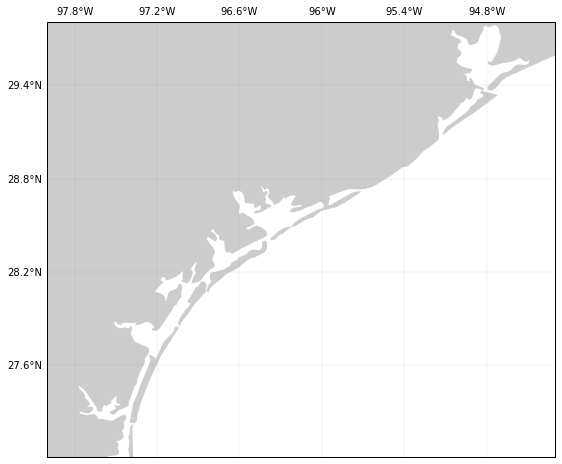

In [152]:
fig, axes = plt.subplots(1,1, subplot_kw={'projection': merc}, figsize=(15,8))
ax = axes
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent([-98, -94.3, 27, 29.8], pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False
ax.add_feature(land_10m, facecolor='0.8')
ax.set_facecolor('0.8')

ax.pcolormesh(ds.kd_490.sel(time=slice('2017-9-20','2017-9-30'), longitude=slice(-98,-94.3), latitude=slice(29.8, 27)).mean('time'), transform=pc)


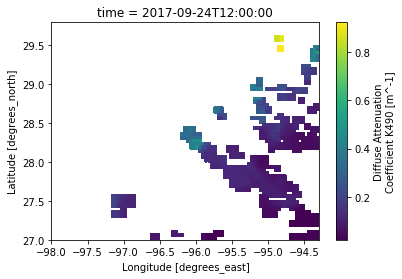

In [181]:
ds.k490.sel(time=slice('2017-9-20','2017-9-30'), longitude=slice(-98,-94.3), latitude=slice(29.8, 27)).isel(time=4).plot()


/Users/kthyng/miniconda3/envs/cart/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


ValueError: too many values to unpack (expected 2)

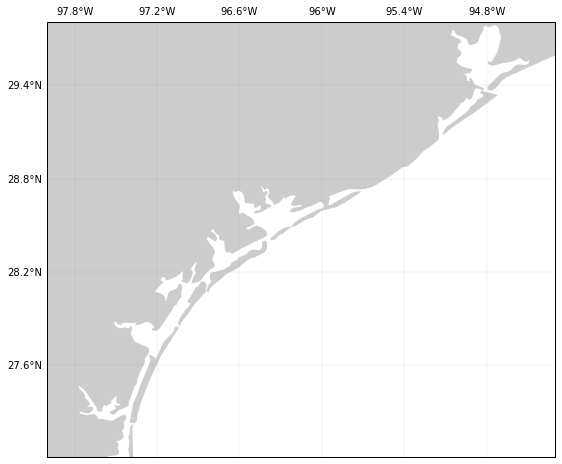

In [144]:
fig, axes = plt.subplots(1,1, subplot_kw={'projection': merc}, figsize=(15,8))
ax = axes
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent([-98, -94.3, 27, 29.8], pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False
ax.add_feature(land_10m, facecolor='0.8')
ax.set_facecolor('0.8')

ax.pcolormesh(ds.kd_490.sel(time=slice('2017-9-20','2017-9-30'), longitude=slice(-98,-94.3), latitude=slice(29.8, 27)).mean('time'))


In [150]:
ds.kd_490.sel(time=slice('2017-9-20','2017-10-30'), longitude=slice(-98,-94.3), latitude=slice(29.8, 27))#.isel(time=0)

<xarray.DataArray 'kd_490' (time: 1, altitude: 1, latitude: 75, longitude: 98)>
array([[[[   nan, ...,    nan],
         ...,
         [   nan, ..., 0.0314]]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2017-10-01T12:00:00
  * altitude   (altitude) float64 0.0
  * latitude   (latitude) float32 29.79375 29.756248 ... 27.056252 27.01875
  * longitude  (longitude) float32 -97.96874 -97.931244 ... -94.331245
Attributes:
    cell_methods:           time:mean(interval:1 month)
    colorBarMaximum:        4.0
    colorBarMinimum:        0.0
    coverage_content_type:  physicalMeasurement
    grid_mapping:           coord_ref
    ioos_category:          Optical Properties
    long_name:              Diffuse attenuation coefficient at 490 nm, kd2 al...
    references:             Wang, M., S. Son, and L. W. Harding, Jr. (2009), ...
    standard_name:          diffuse_attenuation_coefficient_of_downwelling_ra...
    units:                  m^-1
    valid_max:              

In [183]:
loc = 'http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USEGC/6km/hourly/RTV/HFRADAR_US_East_and_Gulf_Coast_6km_Resolution_Hourly_RTV_best.ncd'
hf = xr.open_dataset(loc)


<xarray.DataArray 'DOPx' (time: 69086, lat: 460, lon: 701)>
[22277471560 values with dtype=float32]
Coordinates:
  * lat       (lat) float32 21.73596 21.7899 21.84384 ... 46.44048 46.49442
  * lon       (lon) float32 -97.88385 -97.825775 ... -57.289284 -57.23121
  * time      (time) datetime64[ns] 2012-01-01 ... 2019-11-20T22:00:00
    time_run  (time) datetime64[ns] ...
Attributes:
    long_name:    longitudinal dilution of precision
    comment:      The longitudinal dilution of precision (DOPx) represents th...
    _ChunkSizes:  [  1 460 701]

In [185]:
print(hf.DOPx.comment)

The longitudinal dilution of precision (DOPx) represents the
contribution of the radars' configuration geometry to
uncertainty in the eastward velocity estimate (u). DOPx is a
direct multiplier of the standard error in obtaining the
standard deviation for the eastward velocity estimate from the
least squares best fit. DOPx and DOPy are commonly used to
obtain the geometric dilution of precision
(GDOP = sqrt(DOPx^2 + DOPy^2)), a useful metric for filtering
errant velocities due to poor geometry.


In [186]:
hf.sel(lon=slice(-98,-94.3), lat=slice(29.8, 27))

<xarray.Dataset>
Dimensions:       (lat: 0, lon: 62, nProcParam: 7, nSites: 39, time: 69086)
Coordinates:
  * lat           (lat) float32 
  * lon           (lon) float32 -97.88385 -97.825775 ... -94.39934 -94.34126
  * time          (time) datetime64[ns] 2012-01-01 ... 2019-11-20T22:00:00
    time_run      (time) datetime64[ns] ...
Dimensions without coordinates: nProcParam, nSites
Data variables:
    site_lat      (nSites) float32 ...
    site_lon      (nSites) float32 ...
    site_code     (nSites) |S64 ...
    site_netCode  (nSites) |S64 ...
    procParams    (nProcParam) float32 ...
    time_offset   (time) datetime64[ns] ...
    u             (time, lat, lon) float32 ...
    v             (time, lat, lon) float32 ...
    DOPx          (time, lat, lon) float32 ...
    DOPy          (time, lat, lon) float32 ...
Attributes:
    netcdf_library_version:  4.1.3
    format_version:          HFRNet_1.0.0
    product_version:         HFRNet_1.1.05
    Conventions:             CF-1.4
    t

In [ ]:
LOOK AT ERRORS IN HF RADAR DATA?
Looa at waTer props w depth at stations. T-S diagrams